In [3]:
!pip install transformers torch
!pip install transformers tensorflow
!pip install transformers torch torchvision
!pip install git+https://github.com/openai/CLIP.git



  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-cnhkz82j
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-cnhkz82j
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=5fa2294281f28d9e298b559eedc75c39300ef40d4e6f1a5458b20aecfab13b00
  Stored in directory: /tmp/pip-ephem-wheel-cache-scj719ea/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [10]:
import torch
import numpy as np
import clip
import os
from PIL import Image, ImageFilter
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns

class CLIPRobustnessAnalyzer:
    def __init__(self, model_name="ViT-B/32"):
        """
        Initialize CLIP model for robustness analysis

        Args:
            model_name (str): CLIP model variant to use
        """
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model, self.preprocess = clip.load(model_name, self.device)
        self.model.eval()

        # Define transformation categories
        self.transformations = {
            'original': lambda x: x,
            'gaussian_noise': self._add_gaussian_noise,
            'blur': self._apply_blur,
            'brightness': self._adjust_brightness,
            'contrast': self._adjust_contrast,
            'rotation': self._rotate_image,
            'compression': self._jpeg_compression
        }

        # Predefined zero-shot classes (can be expanded)
        self.classes = [
            "a photo of a cat",
            "a photo of a dog",
            "a photo of a bird",
            "a photo of a car",
            "a photo of a bicycle"
        ]

    def _add_gaussian_noise(self, image, noise_factor=0.1):
        """Add Gaussian noise to an image"""
        img_array = np.array(image) / 255.0
        noise = np.random.normal(0, noise_factor, img_array.shape)
        noisy_img = np.clip(img_array + noise, 0, 1)
        return Image.fromarray((noisy_img * 255).astype(np.uint8))

    def _apply_blur(self, image, radius=2):
        """Apply Gaussian blur to an image"""
        return image.filter(ImageFilter.GaussianBlur(radius))

    def _adjust_brightness(self, image, factor=1.5):
        """Adjust image brightness"""
        enhancer = transforms.functional.adjust_brightness(image, factor)
        return enhancer

    def _adjust_contrast(self, image, factor=1.5):
        """Adjust image contrast"""
        enhancer = transforms.functional.adjust_contrast(image, factor)
        return enhancer

    def _rotate_image(self, image, angle=45):
        """Rotate image"""
        return image.rotate(angle)

    def _jpeg_compression(self, image, quality=20):
        """Apply JPEG compression"""
        temp_file = "temp_compressed.jpg"
        image.save(temp_file, "JPEG", quality=quality)
        return Image.open(temp_file)

    def analyze_robustness_batch(self, image_paths, severity_levels=None):
        """
        Analyze robustness for multiple images

        Args:
            image_paths (list): List of paths to input images
            severity_levels (dict): Custom severity levels for transformations

        Returns:
            dict: Robustness analysis results for all images
        """
        # Load images
        images = [Image.open(path).convert('RGB') for path in image_paths]

        # Default severity levels if not provided
        if severity_levels is None:
            severity_levels = {
                'gaussian_noise': [0.3, 0.5, 0.7],
                'blur': [5, 7, 10],
                'brightness': [0.2, 2.0, 3.0],
                'contrast': [0.2, 2.0, 3.0],
                'rotation': [135, 180, 360],
                'compression': [5, 1]
            }

        # Batch results storage
        batch_results = []

        # Analyze each image
        for idx, original_image in enumerate(images):
            # Analyze robustness for this image
            results = {}
            for transform_name, transform_func in self.transformations.items():
                transform_results = []

                # Original image processing
                if transform_name == 'original':
                    transform_results = self._process_image(original_image)
                    results[transform_name] = transform_results
                    continue

                # Process image with different severity levels
                severity_results = []
                for severity in severity_levels.get(transform_name, [None]):
                    # Apply transformation
                    if severity is not None:
                        if transform_name in ['blur', 'rotation']:
                            transformed_image = transform_func(original_image, severity)
                        elif transform_name in ['gaussian_noise', 'brightness', 'contrast', 'compression']:
                            transformed_image = transform_func(original_image, severity)

                    # Compute zero-shot classification
                    classification_result = self._process_image(transformed_image)
                    severity_results.append({
                        'severity': severity,
                        'results': classification_result
                    })

                results[transform_name] = severity_results

            # Store results for this image
            batch_results.append({
                'image_path': image_paths[idx],
                'robustness_results': results
            })

        return batch_results

    def _process_image(self, image):
        """
        Perform zero-shot classification on an image

        Args:
            image (PIL.Image): Input image

        Returns:
            list: Classification probabilities
        """
        # Preprocess image
        image_input = self.preprocess(image).unsqueeze(0).to(self.device)

        # Tokenize text descriptions
        text_inputs = clip.tokenize(self.classes).to(self.device)

        # Compute similarities
        with torch.no_grad():
            image_features = self.model.encode_image(image_input)
            text_features = self.model.encode_text(text_inputs)

            # Compute similarity logits
            logits = (image_features @ text_features.T).softmax(dim=-1)

        return logits.cpu().numpy()[0]

    def visualize_robustness_batch(self, batch_results):
        """
        Create visualization of robustness analysis for multiple images

        Args:
            batch_results (list): Robustness analysis results for multiple images
        """
        num_images = len(batch_results)
        fig, axes = plt.subplots(num_images, 1, figsize=(15, 5*num_images))

        # Ensure axes is always a list
        if num_images == 1:
            axes = [axes]

        for idx, image_result in enumerate(batch_results):
            results = image_result['robustness_results']

            # Prepare data for heatmap
            transform_names = list(results.keys())
            transform_names.remove('original')

            heatmap_data = []
            for transform in transform_names:
                transform_results = results[transform]
                class_probs = [item['results'] for item in transform_results]

                # Compute average probabilities across all severities
                avg_probs = np.mean(class_probs, axis=0)
                heatmap_data.append(avg_probs)

            # Create heatmap
            sns.heatmap(
                heatmap_data,
                annot=True,
                cmap='YlGnBu',
                xticklabels=self.classes,
                yticklabels=transform_names,
                ax=axes[idx]
            )
            axes[idx].set_title(f'Robustness Analysis - {os.path.basename(image_result["image_path"])}')

        plt.tight_layout()
        plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


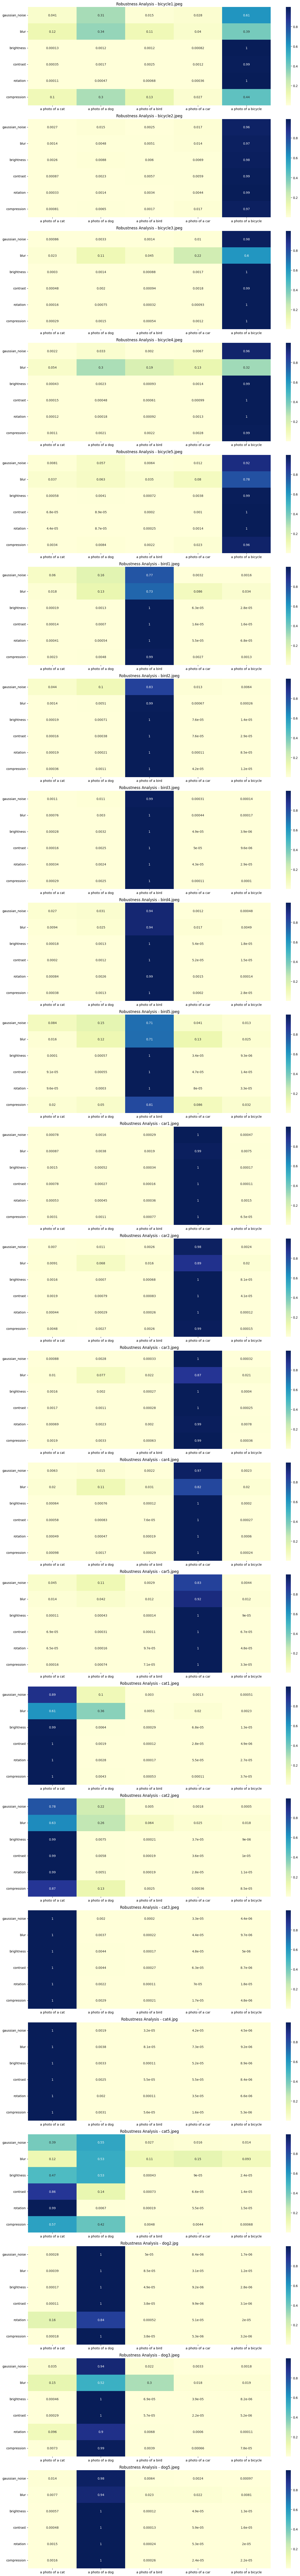

In [11]:
from google.colab import drive
drive.mount('/content/drive')


# Example usage
def main():
    # List of image paths
    image_paths = [
        '/content/bicycle1.jpeg',
        '/content/bicycle2.jpeg',
        '/content/bicycle3.jpeg',
        '/content/bicycle4.jpeg',
        '/content/bicycle5.jpeg',
        '/content/bird1.jpeg',
        '/content/bird2.jpeg',
        '/content/bird3.jpeg',
        '/content/bird4.jpeg',
        '/content/bird5.jpeg',
        '/content/car1.jpeg',
        '/content/car2.jpeg',
        '/content/car3.jpeg',
        '/content/car4.jpeg',
        '/content/car5.jpeg',
        '/content/cat1.jpeg',
        '/content/cat2.jpeg',
        '/content/cat3.jpeg',
        '/content/cat4.jpg',
        '/content/cat5.jpeg',
        '/content/dog2.jpg',
        '/content/dog3.jpeg',
        '/content/dog5.jpeg',

    ]

    # Initialize robustness analyzer
    robustness_analyzer = CLIPRobustnessAnalyzer()

    # Analyze robustness for multiple images
    batch_results = robustness_analyzer.analyze_robustness_batch(image_paths)

    # Visualize results
    robustness_analyzer.visualize_robustness_batch(batch_results)


if __name__ == "__main__":
    main()